![Alt text](new.png)

# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import product  # Import product for grid search

# Method 1: Student proposed equation


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    """
    Fits strain rate dependency for each row in a dataset and exports results.
    
    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    
    Output:
    - CSV file with columns: PEEQ, C1, C2, R_squared for each row in the dataset.
    """
    # Load the temperature-specific file
    data = pd.read_csv(f"../{temperature_file}.csv")
    
    # Default rows to plot
    plot_indices = []
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1e6

    # Define the strain-rate dependency function
    def strain_rate_dependent_stress(sr, C1, C2):
        return C1 * np.log(sr) + C2

    # List to store the results
    results = []


    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract reference stress data from 'StrRt0.0001' for each row
        ref_stress_values = data['StrRt0.0001'].iloc[i]

        # Extract stress data for other strain rates
        stress_values = data.iloc[i][strain_rate_columns].values
        
        # Initial guess and bounds for C1 and C2
        initial_guess_sr = [50e-6, 1900e-6]  # Adjusted initial guesses
        
        # Perform the curve fitting
        try:
            params_sr, _ = curve_fit(
                lambda sr, C1, C2: strain_rate_dependent_stress(sr, C1, C2),
                strain_rates, stress_values, p0=initial_guess_sr, maxfev=10000000, method='dogbox'
            )
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        
        # Calculate residuals and R-squared
        stress_fit = strain_rate_dependent_stress(strain_rates, *params_sr)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": data['strain'].iloc[i],
            "C1": params_sr[0],
            "C2": params_sr[1],
            "R_squared": r_squared
        })
        
        plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
        plt_stress_fit = strain_rate_dependent_stress(plt_strain_rates, *params_sr)
        # Plot only for specified rows with scaled C1 and C2 in legend
        if i in plot_indices:
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(plt_strain_rates, plt_stress_fit, '-', label='Fit')  # Use only original strain rates for fit plot
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([f'Row {i}', f'Fit: C1={params_sr[0] * scale_factor:.2f} x 1e-6, C2={params_sr[1] * scale_factor:.2f} x 1e-6'], loc="lower right")
            plt.grid()
            plt.show()

    # Export results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"Parameters_{temperature_file}.csv", index=False)



## Finding parameters

In [8]:
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    fit_strain_rate_dependency(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

# Check R1 score
## Check to see if any R1 < 0.95

In [9]:
import pandas as pd

def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports the count
    and percentage of rows with R_squared below a specified threshold.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints the count and percentage of rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.98
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"Parameters_{temp_file}.csv")
        
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_low_r_squared = df[df['R_squared'] < threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_low_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_low_r_squared > 0:
            print(f"Number of rows with R_squared < {threshold}: {count_low_r_squared}")
            print(f"Percentage of rows with R_squared < {threshold}: {percentage_low_r_squared:.2f}%")
        else:
            print(f"All R_squared values are >= {threshold}.")

        r = min(df['R_squared'])
        r_a = sum(df['R_squared'])/total_rows
        print(f'Min = {r}. Average = {r_a}')

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
Number of rows with R_squared < 0.98: 70
Percentage of rows with R_squared < 0.98: 82.35%
Min = 0.4128640953049569. Average = 0.8375732890985292

Temperature File: Parameters_Tmp373.15_RD.csv
Number of rows with R_squared < 0.98: 85
Percentage of rows with R_squared < 0.98: 100.00%
Min = 0.0001383552370983. Average = 0.20945181776977614

Temperature File: Parameters_Tmp473.15_RD.csv
Number of rows with R_squared < 0.98: 85
Percentage of rows with R_squared < 0.98: 100.00%
Min = 3.479180987997488e-05. Average = 0.673698878106903

Temperature File: Parameters_Tmp573.15_RD.csv
Number of rows with R_squared < 0.98: 85
Percentage of rows with R_squared < 0.98: 100.00%
Min = 0.0113256782731314. Average = 0.8044583492985028

Temperature File: Parameters_Tmp673.15_RD.csv
Number of rows with R_squared < 0.98: 58
Percentage of rows with R_squared < 0.98: 68.24%
Min = 0.0246333227845865. Average = 0.9046168577734278


# Calibrate C1, C2 based on strain dependent

## Study relationship between C1, C2
C1, C2 follows the same trend for a condition and is dependent on strain rate => Use the same strain dependent function

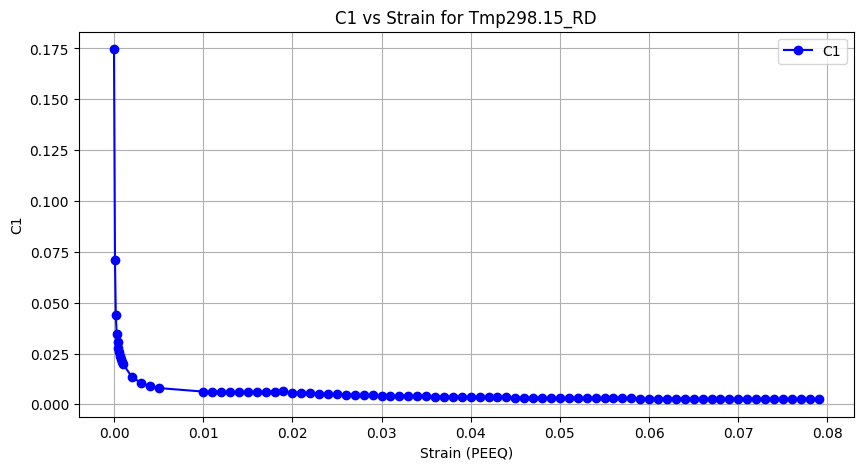

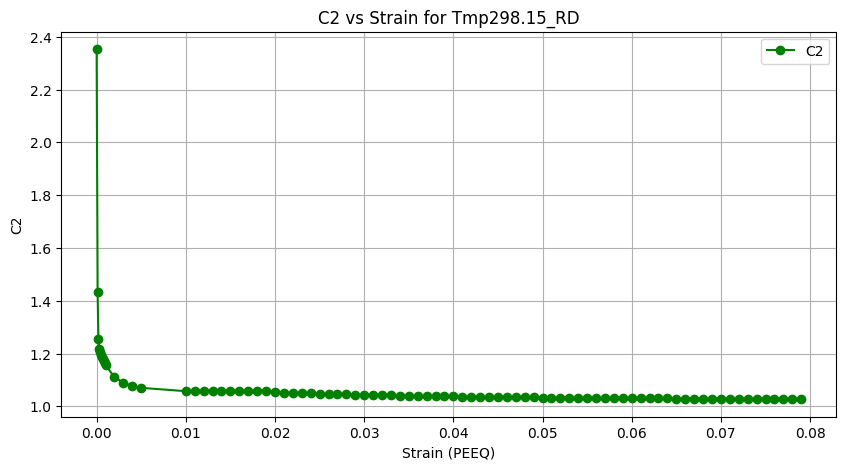

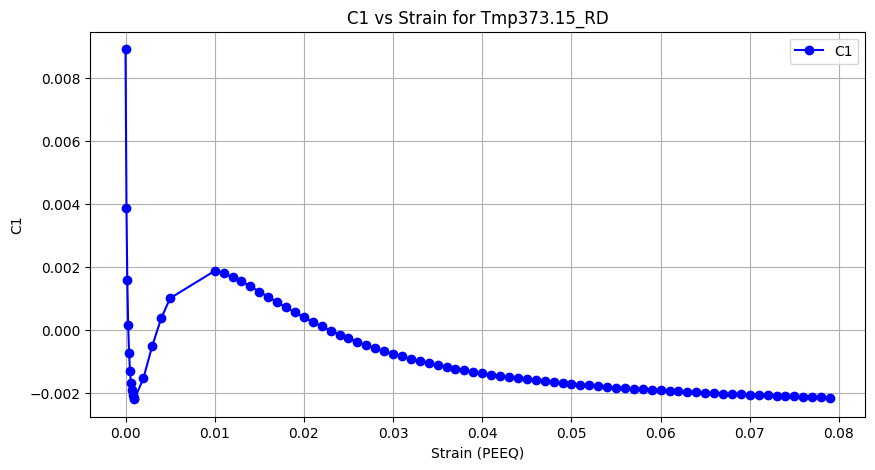

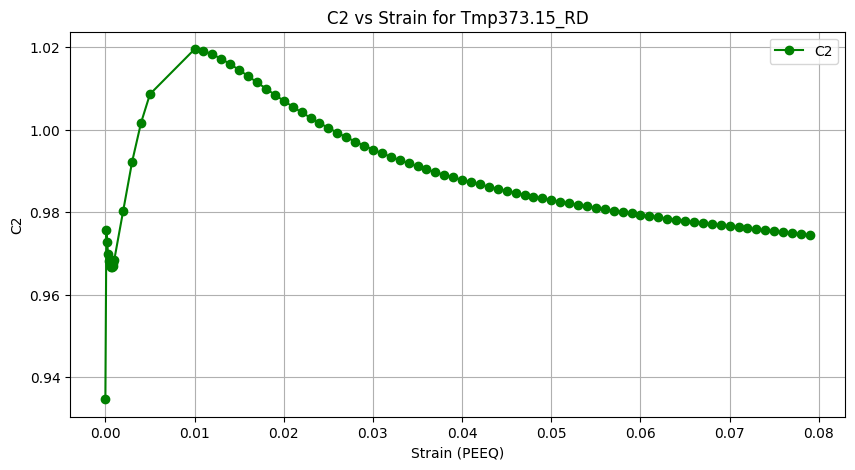

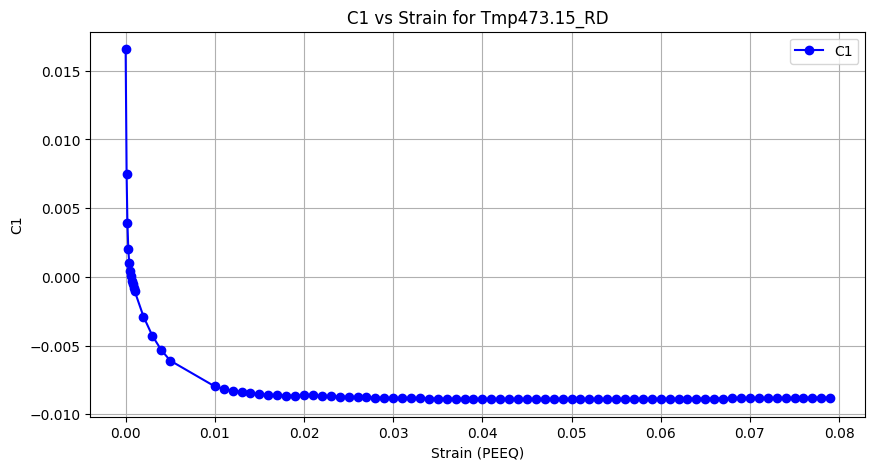

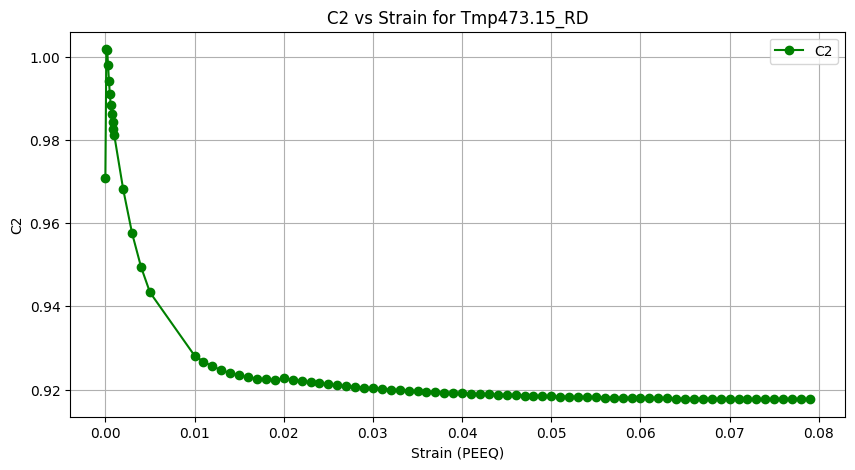

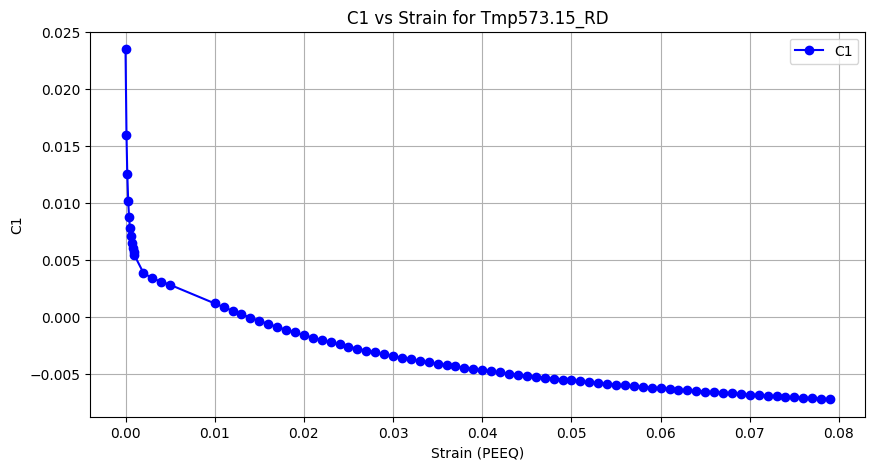

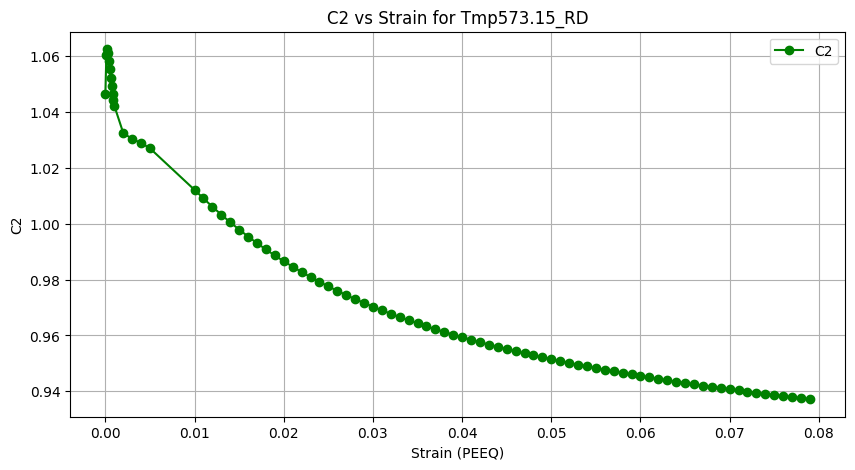

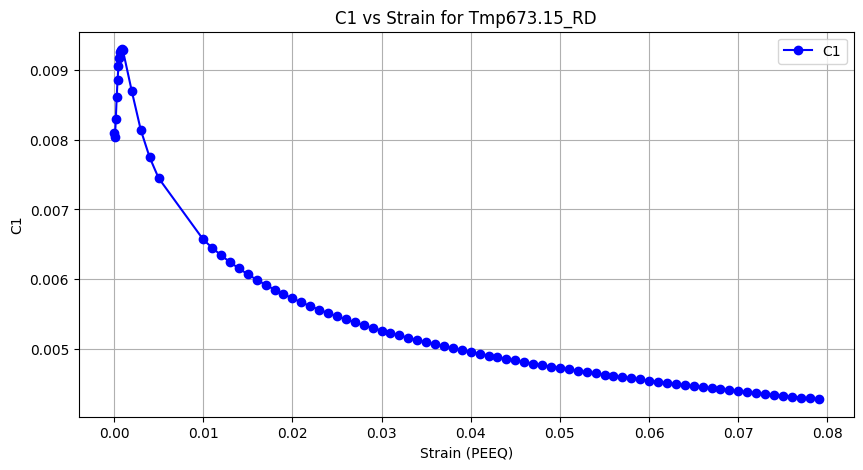

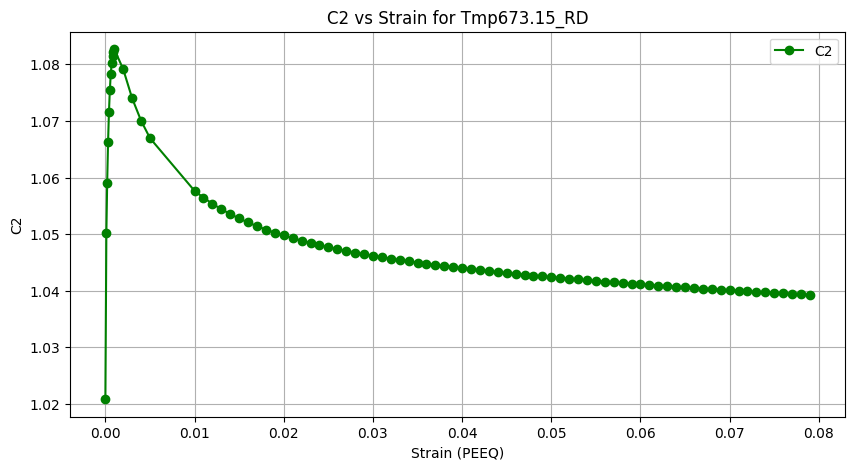

In [4]:
# List of temperature files to load
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}.csv")
    
    # Plot C1 vs. strain with lines
    plt.figure(figsize=(10, 5))
    plt.plot(df['PEEQ'], df['C1'], marker='o', color='blue', label='C1')  # Line plot with points
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.title(f"C1 vs Strain for {temp_file}")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot C2 vs. strain with lines
    plt.figure(figsize=(10, 5))
    plt.plot(df['PEEQ'], df['C2'], marker='o', color='green', label='C2')  # Line plot with points
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.title(f"C2 vs Strain for {temp_file}")
    plt.legend()
    plt.grid()
    plt.show()

## Calibrate strain dependent function for C1 and C2

In [5]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}.csv")  # Replace with your actual file path
    strain = data['PEEQ']  # Strain values
    C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values

    # Define the stretched exponential model
    def stretched_exponential(epsilon, a, b, c, d):
        return a * np.exp(-b * epsilon**c) + d

    # Initial guesses for C1
    initial_guess_C1 = [2.0, 10, 0.5, 0.9]


    # Fit the stretched exponential model to C1
    popt_C1, _ = curve_fit(stretched_exponential, strain, C1_values, p0=initial_guess_C1, maxfev=10000000)

    # Generate strain values for fitting curves
    strain_fit = np.linspace(min(strain), max(strain), 100)

    # Grid search for the best initial guess for C2 parameters
    # Define small ranges around a reasonable starting point for each parameter
    a_range = np.linspace(0, 4.0, 20)      # Wider range for a
    b_range = np.linspace(5, 15, 20)         # Wider range for b
    c_range = np.linspace(0.3, 0.7, 20)      # Wider range for c
    d_range = np.linspace(0.8, 1.2, 20)      # Wider range for d

    best_params_C2 = None
    best_r2_C2 = -np.inf

    # Perform grid search over the parameter ranges
    for a, b, c, d in product(a_range, b_range, c_range, d_range):
        try:
            popt_C2, _ = curve_fit(stretched_exponential, strain, C2_values, p0=[a, b, c, d], maxfev=10000000)
            C2_fitted_values = stretched_exponential(strain, *popt_C2)
            r2_C2 = r2_score(C2_values, C2_fitted_values)
            if r2_C2 > best_r2_C2:
                best_r2_C2 = r2_C2
                best_params_C2 = popt_C2
        except RuntimeError:
            continue

    # Use the best parameters found for C2
    popt_C2 = best_params_C2

    # Generate fitted values using the stretched exponential model
    C1_fit = stretched_exponential(strain_fit, *popt_C1)
    C2_fit = stretched_exponential(strain_fit, *popt_C2)

    # Calculate the fitted values at the original strain points for R^2 score calculation
    C1_fitted_values = stretched_exponential(strain, *popt_C1)
    C2_fitted_values = stretched_exponential(strain, *popt_C2)

    # Calculate R^2 scores
    r2_C1 = r2_score(C1_values, C1_fitted_values)

    # Plot C1 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C1_values, 'o', label='C1 Data')
    plt.plot(strain_fit, C1_fit, '-', label='C1 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.legend()
    plt.title(f"C1 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {r2_C1:.3f})")
    plt.show()
    plt.savefig(f"results/C1_{temp_file}.png")

    # Plot C2 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C2_values, 'o', label='C2 Data')
    plt.plot(strain_fit, C2_fit, '-', label='C2 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {best_r2_C2:.3f})")
    plt.savefig(f"results/C2_{temp_file}.png")
    plt.show()

    # Print the fitted parameters for reference
    print("Stretched Exponential Fit Parameters for C1:", popt_C1)
    print("Best Stretched Exponential Fit Parameters for C2:", best_params_C2)
    print("Best R^2 for C2:", best_r2_C2)

# Example usage:
# calibrate_strain_dependent('Tmp673.15_RD')


In [6]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}.csv")  # Replace with your actual file path
    strain = data['PEEQ']  # Strain values
    C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values

    # Define the stretched exponential model
    def stretched_exponential(epsilon, a, b, c, d):
        return a * np.exp(-b * epsilon**c) + d

    # Initial guesses for C1
    initial_guess_C1 = [2.0, 10, 0.5, 0.9]


    # Fit the stretched exponential model to C1
    popt_C1, _ = curve_fit(stretched_exponential, strain, C1_values, p0=initial_guess_C1, maxfev=10000000)
    popt_C2, _ = curve_fit(stretched_exponential, strain, C2_values, p0=initial_guess_C1, maxfev=10000000)

    # Generate strain values for fitting curves
    strain_fit = np.linspace(min(strain), max(strain), 100)

    # Generate fitted values using the stretched exponential model
    C1_fit = stretched_exponential(strain_fit, *popt_C1)
    C2_fit = stretched_exponential(strain_fit, *popt_C2)

    # Calculate the fitted values at the original strain points for R^2 score calculation
    C1_fitted_values = stretched_exponential(strain, *popt_C1)
    C2_fitted_values = stretched_exponential(strain, *popt_C2)

    # Calculate R^2 scores
    r2_C1 = r2_score(C1_values, C1_fitted_values)
    r2_C2 = r2_score(C2_values, C2_fitted_values)

    # Plot C1 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C1_values, 'o', label='C1 Data')
    plt.plot(strain_fit, C1_fit, '-', label='C1 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.legend()
    plt.title(f"C1 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {r2_C1:.3f})")
    plt.show()

    # Plot C2 vs Strain with stretched exponential fit
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C2_values, 'o', label='C2 Data')
    plt.plot(strain_fit, C2_fit, '-', label='C2 Fit (Stretched Exponential)')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain with Stretched Exponential Fit {temp_file} (R^2: {r2_C2:.3f})")
    plt.show()

    # Print the fitted parameters for reference
    print("Stretched Exponential Fit Parameters for C1:", popt_C1)
    print("Stretched Exponential Fit Parameters for C1:", popt_C2)

# Example usage:
# calibrate_strain_dependent('Tmp673.15_RD')


In [7]:
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    calibrate_strain_dependent(temp_file)

NameError: name 'r2_score' is not defined

# Bonus

Temperature dependence and normalized stress

In [ ]:
'''
ref_temp = '298.15'

#First set, comment out second set to generate for this one
strain_rates = [0.0001]
temps = ['77.15', '233.15', '298.15', '373.15', '473.15', '573.15', '673.15']

#Second set
strain_rates = [0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

for strain_rate in strain_rates:
    # Load reference stress data at 298.15 K for the given strain rate
    data_RD_ref = pd.read_csv(f'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    ref_stress_RD = data_RD_ref['Stress']  # Stress column at reference temperature
    
    # Initialize DataFrame with strain column
    df = pd.DataFrame({'strain': data_RD_ref['Strain']})
    
    # Loop over each temperature to calculate and add normalized stress columns
    for temp in temps:
        # Load stress data at the current temperature
        temp_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        # Calculate normalized stress by dividing by reference stress at 298.15 K
        normalized_stress_RD = temp_RD / ref_stress_RD
        
        # Add normalized stress as a column in the DataFrame
        df[f'Tmp{temp}K_ref'] = normalized_stress_RD

    # Save the DataFrame to a CSV file
    df = df[df['strain'] < 0.08]
    output_file_path = f"StrainRate{strain_rate}_RD.csv"
    df.to_csv(output_file_path, index=False)
'''

'''
def organise_data_normalized(strain_rates, temps):
    ref_temp = '298.15'
    
    # Loop over each temperature
    for temp in temps:
        df = None  # Initialize df to None to handle it dynamically for each temperature
        
        for strain_rate in strain_rates:
            # Load reference stress data at 298.15 K for the given strain rate
            data_RD_ref = pd.read_csv(f'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
            ref_stress_RD = data_RD_ref['Stress']
            
            # Load current temperature stress data for the given strain rate
            data_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')
            
            # Calculate normalized stress
            normalized_stress_RD = data_RD['Stress'] / ref_stress_RD
            
            if df is None:
                # Initialize DataFrame with strain column if not already done
                df = pd.DataFrame({'strain': data_RD['Strain']})
            
            # Add normalized stress data for the current strain rate as a new column
            df[f'StrRt{strain_rate}'] = normalized_stress_RD

        # Filter the DataFrame for strain values below 0.08
        df = df[df['strain'] < 0.08]
        
        # Save the DataFrame to a CSV file for the current temperature
        output_file_path = f"Tmp{temp}_RD_normalized.csv"
        df.to_csv(output_file_path, index=False)
'''

'\ndef organise_data_normalized(strain_rates, temps):\n    ref_temp = \'298.15\'\n    \n    # Loop over each temperature\n    for temp in temps:\n        df = None  # Initialize df to None to handle it dynamically for each temperature\n        \n        for strain_rate in strain_rates:\n            # Load reference stress data at 298.15 K for the given strain rate\n            data_RD_ref = pd.read_csv(f\'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv\')\n            ref_stress_RD = data_RD_ref[\'Stress\']\n            \n            # Load current temperature stress data for the given strain rate\n            data_RD = pd.read_csv(f\'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv\')\n            \n            # Calculate normalized stress\n            normalized_stress_RD = data_RD[\'Stress\'] / ref_stress_RD\n            \n            if df is None:\n                # Initialize DataFrame with strain column if not already done\n                df = pd.DataFrame({\'